In [180]:
!pip install pulp

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import *

In [182]:
############################## import data ###################################

def read_excel_data(filename, sheet_name):
        data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
        values = data.values
        return values

filename = "data.xlsx"
sheet_name = "Lines"
lines = read_excel_data(filename, sheet_name)[1:,:]
sheet_name = "Buses"
buses = read_excel_data(filename, sheet_name)[1:,:]
Nb = buses[:,1].size
Nl = lines[:,1].size
genCost = buses[:,5]
genMax = buses[:,4]
Pmax = sum(genMax)            #This gives 25MW
sheet_name = "Loads"
loads = read_excel_data(filename, sheet_name)[2:,1:Nb+1]
sheet_name = "PV production"
pv = read_excel_data(filename, sheet_name)[2:,1:Nb+1]
sheet_name = "Wind production"
wind = read_excel_data(filename, sheet_name)[2:,1:Nb+1]
sheet_name = "Buses"
batt = read_excel_data(filename, sheet_name)[1:,6]

In [183]:
Nt= 24
# create incidence matrix
Mi = np.zeros((Nl,Nb),int)
for l in range(Nl):
    i = int(lines[l,0])
    j = int(lines[l,1])
    Mi[l, i-1] = -1
    Mi[l, j-1] = 1

print("Incidence matrix:")
print(Mi)

Incidence matrix:
[[-1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 -1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 -1  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 -1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  1]]


In [184]:
set_I = [i for i in range(1,Nb+1)]  # set of buses
set_L = [i for i in range(1,Nl+1)]  # set of electrical lines
set_T = [i for i in range(1,Nt+1)]  # set of time steps

## **1. Add Renewable Energy (RE) production (PV, WT). What is the RE share in the energy production?**



In [147]:
# Create the 'electrical_byNetwork' variable to contain the problem data
electrical_Network = LpProblem("electrical_Network", LpMinimize)

# Create variables
Pg_it = LpVariable.dicts('Pg_it', (set_I, set_T), 0, Pmax, cat='Continuous')                   # Generated powers in each node (The generated power at each bus costs money)
Pl_it = LpVariable.dicts('Pl_it', (set_L, set_T), -Pmax, Pmax, cat='Continuous')               # Transferred powers in each elecrical line
P_it = LpVariable.dicts('P_it', (set_I, set_T), -Pmax, Pmax, cat='Continuous')                 # Injected powers to the grid from each node (On some buses, no generator, only load)
Ppv_it  = LpVariable.dicts('Ppv_it',  (set_I, set_T), 0, Pmax, cat='Continuous')
Pwt_it  = LpVariable.dicts('Pwt_it',  (set_I, set_T), 0, Pmax, cat='Continuous')

# Add the objective function
electrical_Network += lpSum(genCost[i-1]*Pg_it[i][t]*1000 for i in set_I for t in set_T)

# Energy balance in the nodes
for t in set_T:
    for i in set_I:                                                 #  Since renewables are free, we can give more power than the load required hence we changed from == to >=
        electrical_Network += Pg_it[i][t] - loads[t-1,i-1] + Ppv_it[i][t]  + Pwt_it[i][t] == P_it[i][t]      # Array starts from 1, and 0

# Energy balance in the network (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += P_it[i][t] == lpSum(Mi[j-1,i-1]*Pl_it[j][t] for j in set_L)

# Maximal power generation (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] <= genMax[i-1]

# Maximal generation of PV arrays
for t in set_T:
    for i in set_I:
        electrical_Network += Ppv_it[i][t] <= 0.001*pv[t-1,i-1]

# Maximal generation of Wind
for t in set_T:
    for i in set_I:
        electrical_Network += Pwt_it[i][t] <= 0.001*wind[t-1,i-1]

In [148]:
# The problem is solved using PuLP's choice of Solver(the default solver is Coin Cbc)
electrical_Network.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[electrical_Network.status])

Status: Optimal


In [149]:
print ("Optimal generation cost = ", value(electrical_Network.objective))

Optimal generation cost =  1791.9849099999997


<ipython-input-150-1f1f2361e926>:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
<ipython-input-150-1f1f2361e926>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,2]=np.sum(pv[t-1,i-1]*0.001 for i in range(1,Nb))
<ipython-input-150-1f1f2361e926>:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,3]=np.sum(wind[t-1,i-1]*0.001 for i in range(1,Nb))


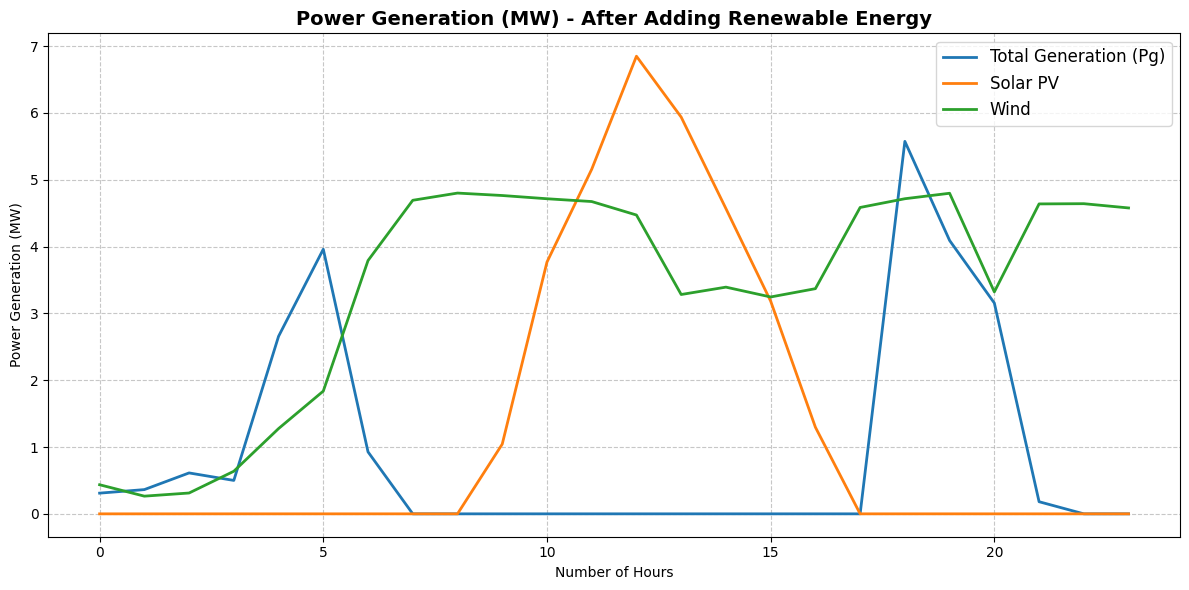

In [150]:
#getting the contribution of wind and PV to overall generation
power_distribution = np.zeros((Nt,4))
#print(power_distribution)
for t in set_T:
    power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
    power_distribution[t-1,2]=np.sum(pv[t-1,i-1]*0.001 for i in range(1,Nb))
    power_distribution[t-1,3]=np.sum(wind[t-1,i-1]*0.001 for i in range(1,Nb))
power_distribution[:,0]= np.arange(24)
df = pd.DataFrame(power_distribution, columns=["x","Pg", "PV", "Wind"])
# Enhanced plot with improved labels, gridlines, and formatting
ax = df.plot(
    x="x",
    y=["Pg", "PV", "Wind"],
    kind="line",
    rot=0,
    figsize=(12, 6),
    linewidth=2,
    xlabel="Number of Hours",
    ylabel="Power Generation (MW)",
)
ax.set_title("Power Generation (MW) - After Adding Renewable Energy", fontsize=14, weight='bold')
ax.legend(["Total Generation (Pg)", "Solar PV", "Wind"], fontsize=12)
ax.grid(True, linestyle="--", alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()
total_dis = power_distribution.sum(axis=0)

total_dis = total_dis[1:4]*100/np.sum(total_dis[1:4])

import matplotlib.pyplot as plt

The optimal generation cost is 1791.98 units. The graph depicting hourly power generation variations across different sources reveals the following insights:

**Gas Engine Utilization**:
The gas engine is predominantly utilized during the evening (from 17:00) to early morning (07:30).
This period corresponds to zero photovoltaic (PV) power production and insufficient wind power generation to meet the demand.

**Photovoltaic Power Contribution:**
Starting around 07:30, photovoltaic power production begins.
During this time, both PV and wind power work together to share the load.

**Evening Transition:**
As photovoltaic power production ceases around 17:00, the gas engine takes over and shares the load with wind power to ensure demand is met.

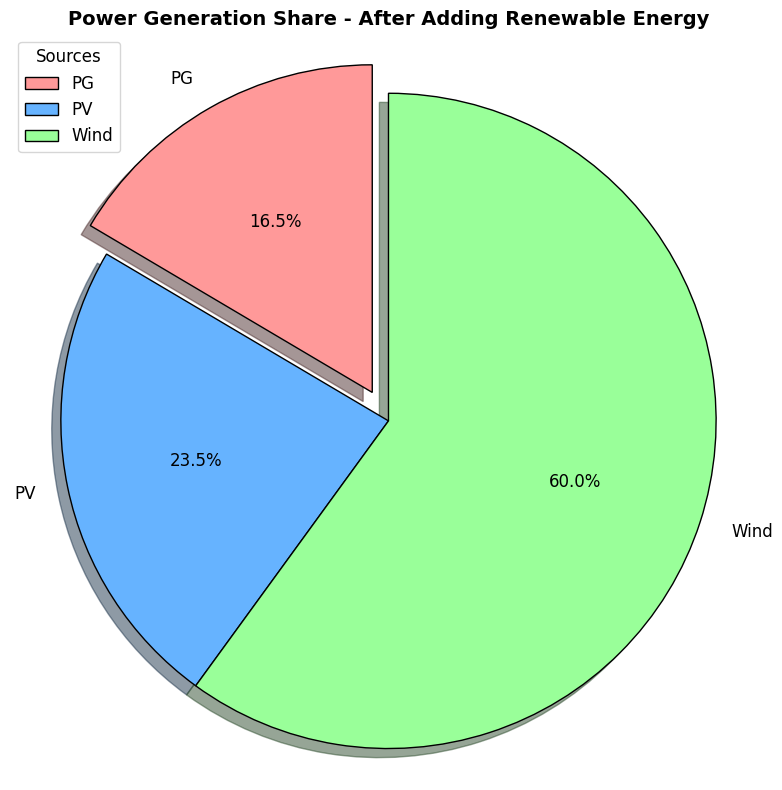

In [151]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ["PG", "PV", "Wind"]
sizes = total_dis
explode = (0.1, 0, 0)  # "explode" PG for emphasis
colors = ["#ff9999", "#66b3ff", "#99ff99"]  # Custom colors for better visualization

# Create the pie chart
fig1, ax1 = plt.subplots(figsize=(8, 8))  # Larger figure for better readability
wedges, texts, autotexts = ax1.pie(
    sizes,
    explode=explode,
    labels=labels,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12},  # Increase font size of labels
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'},  # Add edge for better distinction
)

# Set the title
ax1.set_title("Power Generation Share - After Adding Renewable Energy", fontsize=14, weight="bold")

# Customize the legend
ax1.legend(
    wedges,
    labels,
    title="Sources",
    loc="upper left",
    fontsize=12,
    title_fontsize=12,
)

# Ensure the pie chart is a perfect circle
ax1.axis('equal')

# Display the chart
plt.tight_layout()
plt.show()


The pie chart shows the power generation share after adding renewables. Wind power dominates with 60%, followed by photovoltaic (PV) at 23.5%, and gas engines (PG) at 16.5%. The total renewable energy share is 83.5%, highlighting significant reliance on renewables, while gas engines provide backup during low renewable output periods.

## **2. Add maximum power constraints to the electrical lines, Is there a branch (electrical line) that is sometime saturated?**

In [158]:
# Create the 'electrical_Network' variable to contain the problem data
electrical_Network = LpProblem("electrical_Network", LpMinimize)

PL_MAX  = 1.3  # Maximum Power that can be transmitted through line

Pl_it   = LpVariable.dicts('Pl_it',   (set_L, set_T), -PL_MAX, PL_MAX, cat='Continuous')            # Lines have max 1.3 MW hence
Ppv_it  = LpVariable.dicts('Ppv_it',  (set_I, set_T), 0, Pmax, cat='Continuous')
Pwt_it  = LpVariable.dicts('Pwt_it',  (set_I, set_T), 0, Pmax, cat='Continuous')
Ppv_it  = LpVariable.dicts('Ppv_it',  (set_I, set_T), 0, Pmax, cat='Continuous')
Pwt_it  = LpVariable.dicts('Pwt_it',  (set_I, set_T), 0, Pmax, cat='Continuous')

# Add the objective function
electrical_Network += lpSum(genCost[i-1]*Pg_it[i][t]*1000 for i in set_I for t in set_T)

# Energy balance in the nodes
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] - loads[t-1,i-1] + Ppv_it[i][t]  + Pwt_it[i][t] == P_it[i][t]

# Energy balance in the network (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += P_it[i][t] == lpSum(Mi[j-1,i-1]*Pl_it[j][t] for j in set_L)

# Maximal power generation (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] <= genMax[i-1]

# Maximal generation of PV arrays
for t in set_T:
    for i in set_I:
        electrical_Network += Ppv_it[i][t] <= 0.001*pv[t-1,i-1]

# Maximal generation of Wind
for t in set_T:
    for i in set_I:
        electrical_Network += Pwt_it[i][t] <= 0.001*wind[t-1,i-1]

In [159]:
# The problem is solved using PuLP's choice of Solver(the default solver is Coin Cbc)
electrical_Network.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[electrical_Network.status])

Status: Optimal


In [160]:
print ("Optimal generation cost = ", value(electrical_Network.objective))

Optimal generation cost =  1918.12016


<ipython-input-161-c5c48b5c7f38>:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
<ipython-input-161-c5c48b5c7f38>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,2]=np.sum(value(Ppv_it[i][t]) for i in range(1,Nb))
<ipython-input-161-c5c48b5c7f38>:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,3]=np.sum(value(Pwt_it[i][t]) for i in range(1,Nb))


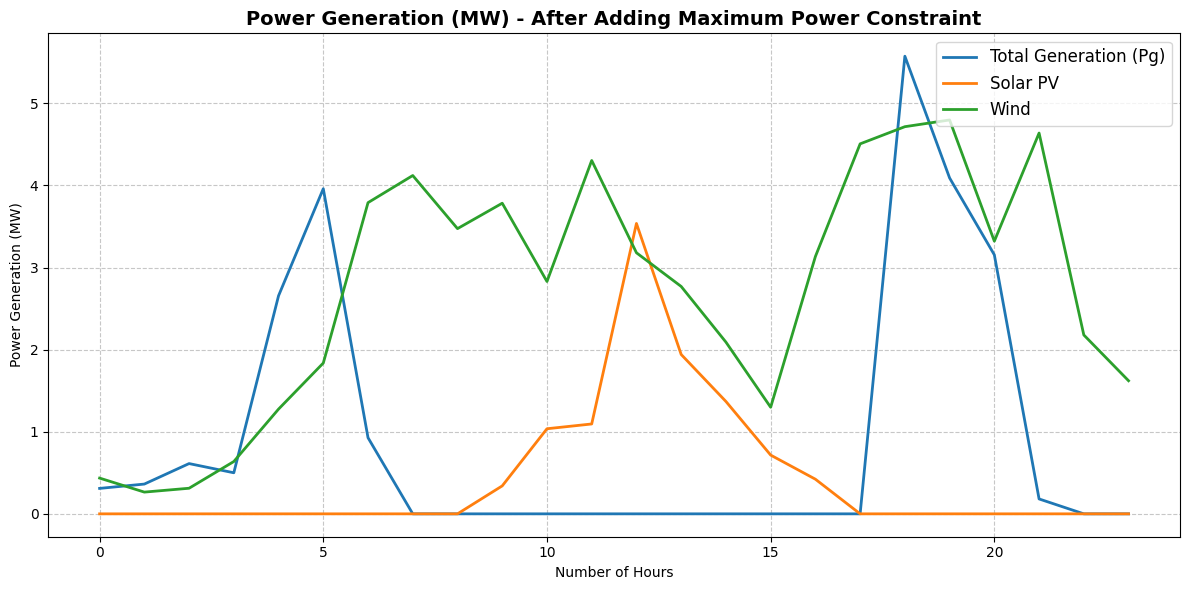

In [161]:
#getting the contribution of wind and PV to overall generation
power_distribution = np.zeros((Nt,4))
#print(power_distribution)
for t in set_T:
    power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
    power_distribution[t-1,2]=np.sum(value(Ppv_it[i][t]) for i in range(1,Nb))
    power_distribution[t-1,3]=np.sum(value(Pwt_it[i][t]) for i in range(1,Nb))
power_distribution[:,0]= np.arange(24)
df = pd.DataFrame(power_distribution, columns=["x","Pg", "PV", "Wind"])
ax = df.plot(
    x="x",
    y=["Pg", "PV", "Wind"],
    kind="line",
    rot=0,
    figsize=(12, 6),
    linewidth=2,
    xlabel="Number of Hours",
    ylabel="Power Generation (MW)",
)
ax.set_title("Power Generation (MW) - After Adding Maximum Power Constraint", fontsize=14, weight='bold')
ax.legend(["Total Generation (Pg)", "Solar PV", "Wind"], fontsize=12, loc="upper right")
ax.grid(True, linestyle="--", alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()
total_dis = power_distribution.sum(axis=0)

total_dis = total_dis[1:4]*100/np.sum(total_dis[1:4])

import matplotlib.pyplot as plt

Optimal Generation Cost =  1918.12016.

In the second scenario, where maximum line limits are applied, the power generation system operates under stricter constraints, leading to noticeable changes in the distribution of generation among sources. The gas engine now operates intermittently in short bursts, as opposed to steady output in the first scenario, likely due to restrictions imposed by line capacity, which limit its continuous utilization. Photovoltaic (PV) power production is also capped, especially during peak daylight hours, as excess production cannot be transmitted due to line constraints, resulting in curtailment of PV output.

Wind power, on the other hand, plays a more prominent role in balancing the system. Its flexibility and distributed nature allow it to adapt to the constrained conditions, leading to higher and more variable contributions. Overall, the application of line limits forces the system to dynamically redistribute generation, prioritizing sources that can operate flexibly within the new constraints. This highlights the challenges of managing grid operations under transmission capacity restrictions and emphasizes the need for storage solutions or grid upgrades to fully utilize renewable energy potential.

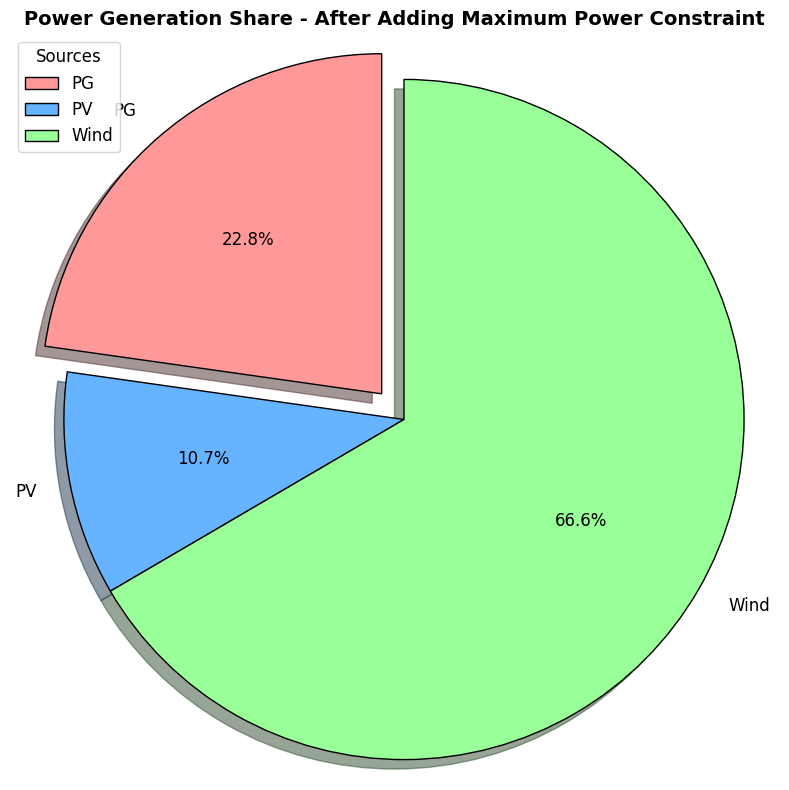

In [162]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ["PG", "PV", "Wind"]
sizes = total_dis
explode = (0.1, 0, 0)  # "explode" PG for emphasis
colors = ["#ff9999", "#66b3ff", "#99ff99"]  # Custom colors for better visualization

# Create the pie chart
fig1, ax1 = plt.subplots(figsize=(8, 8))  # Larger figure for better readability
wedges, texts, autotexts = ax1.pie(
    sizes,
    explode=explode,
    labels=labels,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12},  # Increase font size of labels
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'},  # Add edge for better distinction
)

# Set the title
ax1.set_title("Power Generation Share - After Adding Maximum Power Constraint", fontsize=14, weight="bold")

# Customize the legend
ax1.legend(
    wedges,
    labels,
    title="Sources",
    loc="upper left",
    fontsize=12,
    title_fontsize=12,
)

# Ensure the pie chart is a perfect circle
ax1.axis('equal')

# Display the chart
plt.tight_layout()
plt.show()


The application of maximum power constraints has shifted the energy mix:

Wind power takes the lead as the most reliable source under constrained conditions.
Gas engines provide critical support when wind and PV power cannot meet demand due to line limits.
PV's reduced share highlights the challenge of integrating solar energy into constrained grids, emphasizing the need for enhanced storage or grid upgrades to fully utilize its potential.

*Power at each line to verify the maximum power*

In [163]:
Pg_it_values= np.zeros((Nl,Nt))
for t in set_T:
  for i in set_I:
    Pg_it_values[i-1,t-1]=value( Pl_it[i][t])

import csv
with open('powermax.csv','w', newline='') as csvfile:
  spamwriter = csv.writer(csvfile, delimiter=';',
                        quotechar=',', quoting=csv.QUOTE_MINIMAL)
  for i in set_I:
    spamwriter.writerow(Pg_it_values[:,i-1])

The lines which have values -1.3 and 1.3 are the saturated lines as they reach the max set limits.

## **3. Add batteries where possible. What is the effect of introducing the batteries on the RE share? (There is no maximum storage capacities at this stage)**

In [169]:
# Create the 'electrical_Network' variable to contain the problem data
electrical_Network = LpProblem("electrical_Network", LpMinimize)

#Battery Maximum charging Power
B_chg_MAX = 1  #30% of the battery capacity
chEfficiency = 0.85
disEfficiency = 0.75
chFactor = 1/chEfficiency

# Create variables
Pl_it = LpVariable.dicts('Pl_it', (set_L, set_T), -Pmax, Pmax, cat='Continuous')
B_ch    = LpVariable.dicts('B_ch', (set_I, set_T), 0, Pmax, cat='Continuous')
B_dch   = LpVariable.dicts('B_dch', (set_I, set_T), 0, Pmax, cat='Continuous')
B_cap   = LpVariable.dicts('B_cap', (set_I, set_T), 0, Pmax, cat='Continuous')

# Add the objective function
electrical_Network += lpSum(genCost[i-1]*Pg_it[i][t]*1000 for i in set_I for t in set_T)

# Energy balance in the nodes
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] - loads[t-1,i-1] + pv[t-1,i-1]*0.001 + wind[t-1,i-1]*0.001 - B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency) >= P_it[i][t]

# Energy balance in the network (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += P_it[i][t] == lpSum(Mi[j-1,i-1]*Pl_it[j][t] for j in set_L)

# Maximal power generation (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] <= genMax[i-1]

#Battery State of Charge Equation
for t in set_T:
    for i in set_I:
      if t>1:
         electrical_Network += B_cap[i][t] == B_cap[i][t-1] + B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency)
      else:
        electrical_Network += B_cap[i][t] == 0.0 + B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency)

In [170]:
# The problem is solved using PuLP's choice of Solver(the default solver is Coin Cbc)
electrical_Network.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[electrical_Network.status])

Status: Optimal


In [171]:
print ("Optimal generation cost = ", value(electrical_Network.objective))

Optimal generation cost =  746.2215199999999


<ipython-input-172-452789cac619>:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
<ipython-input-172-452789cac619>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,2]=np.sum(pv[t-1,i-1]*0.001 for i in range(1,Nb))
<ipython-input-172-452789cac619>:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,3]=np.sum(wind[t-1,i-1]*0.001 for i in range(1,Nb))


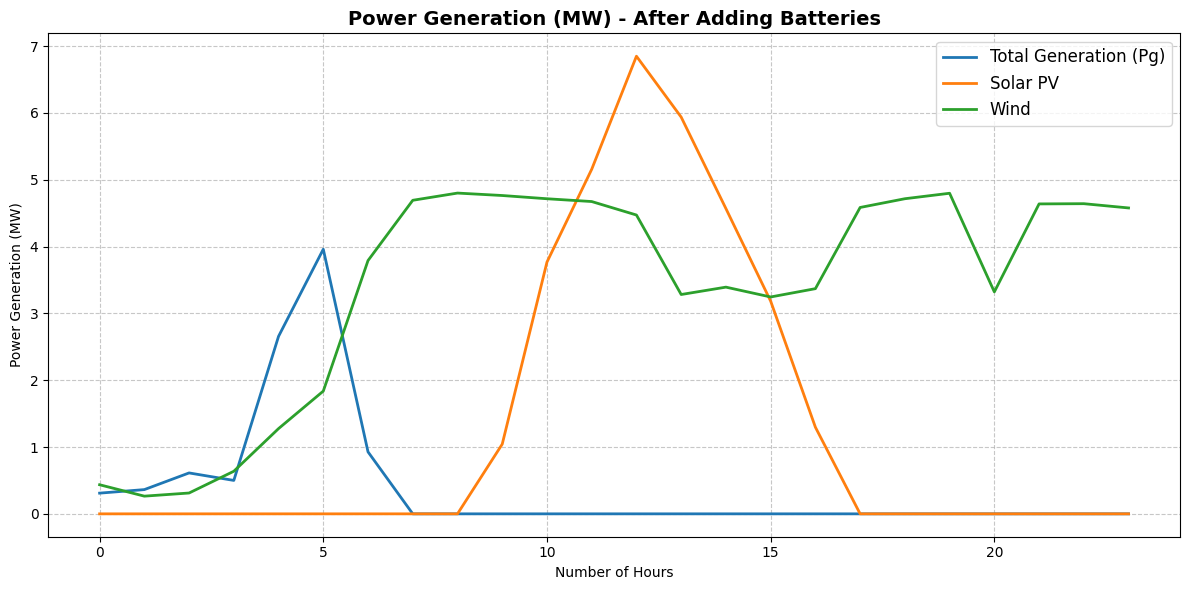

In [172]:
#getting the contribution of wind and PV to overall generation
power_distribution = np.zeros((Nt,4))
#print(power_distribution)
for t in set_T:
    power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
    power_distribution[t-1,2]=np.sum(pv[t-1,i-1]*0.001 for i in range(1,Nb))
    power_distribution[t-1,3]=np.sum(wind[t-1,i-1]*0.001 for i in range(1,Nb))
power_distribution[:,0]= np.arange(24)
df = pd.DataFrame(power_distribution, columns=["x","Pg", "PV", "Wind"])
ax = df.plot(
    x="x",
    y=["Pg", "PV", "Wind"],
    kind="line",
    rot=0,
    figsize=(12, 6),
    linewidth=2,
    xlabel="Number of Hours",
    ylabel="Power Generation (MW)",
)
ax.set_title("Power Generation (MW) - After Adding Batteries", fontsize=14, weight='bold')
ax.legend(["Total Generation (Pg)", "Solar PV", "Wind"], fontsize=12, loc="upper right")
ax.grid(True, linestyle="--", alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()
total_dis = power_distribution.sum(axis=0)

total_dis = total_dis[1:4]*100/np.sum(total_dis[1:4])

import matplotlib.pyplot as plt

Optimal generation cost =  746.2215199999999

The Graph show that after incorporation of Battery, Gas Engine utilization during evening has been stopped. Following 3 points can be concluded from the Graph.

1. Now Gas Engine Power is only utilized in Night from 00:00 hrs to 07:00 hrs.

2. In daytime, excess power produced by Wind Turbine and Photovoltaic is used to recharge the Batteries.

3. The energy stored in Battery is used in evening to repalce the Gas Engine.

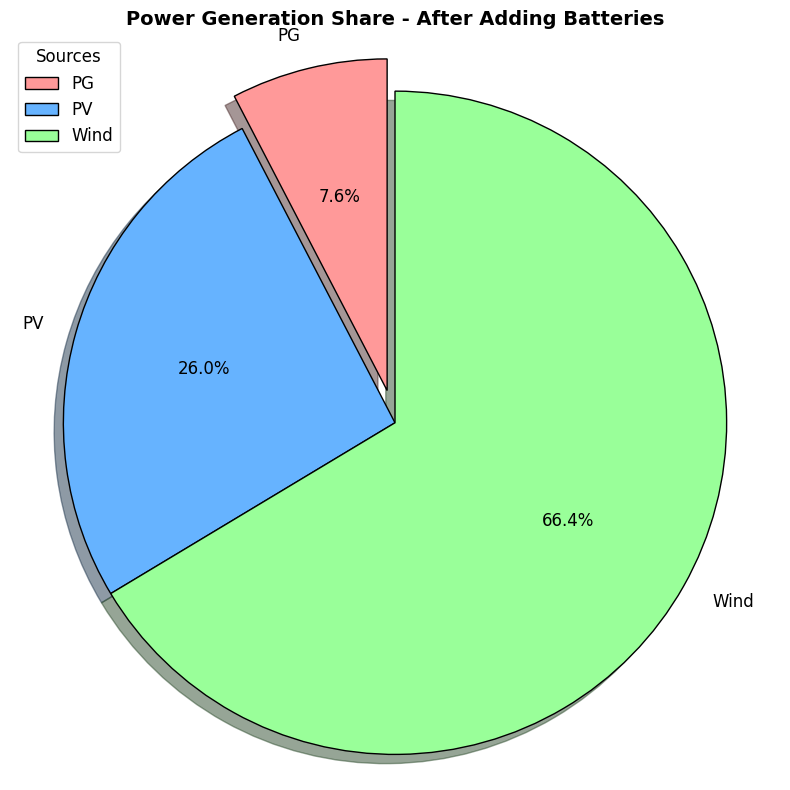

In [173]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ["PG", "PV", "Wind"]
sizes = total_dis
explode = (0.1, 0, 0)  # "explode" PG for emphasis
colors = ["#ff9999", "#66b3ff", "#99ff99"]  # Custom colors for better visualization

# Create the pie chart
fig1, ax1 = plt.subplots(figsize=(8, 8))  # Larger figure for better readability
wedges, texts, autotexts = ax1.pie(
    sizes,
    explode=explode,
    labels=labels,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12},  # Increase font size of labels
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'},  # Add edge for better distinction
)

# Set the title
ax1.set_title("Power Generation Share - After Adding Batteries", fontsize=14, weight="bold")

# Customize the legend
ax1.legend(
    wedges,
    labels,
    title="Sources",
    loc="upper left",
    fontsize=12,
    title_fontsize=12,
)

# Ensure the pie chart is a perfect circle
ax1.axis('equal')

# Display the chart
plt.tight_layout()
plt.show()


1. As expected, the Pie Chart depict the increase in portion of Wind and PV Power Production. This happens because excess power produced from these Renewable sources can be used to charge the Batteries in Daytime.

2. On the other hand, battery installation has led to drop in Gas Engine Power Production from 22.8 % (Only Renewable Energy Sources Installation Case) to 7.6%.

## **4. Change the objective function to introduce an investment cost of 1500 euros/kWh of batteries. What is the impact on the RE share? (life span of the batteries: 8 years, charging efficiency: 0.85,discharging efficiency: 0.75)**

In [175]:
# Create the 'electrical_Network' variable to contain the problem data
electrical_Network = LpProblem("electrical_Network", LpMinimize)

#Battery Investment Cost in euros/MWh
Inv_cost = 1500

# Add the objective function
electrical_Network += lpSum(genCost[i-1]*Pg_it[i][t]*1000 + (B_cap[i][t]*Inv_cost*1000)/(365*8) for i in set_I for t in set_T)

# Energy balance in the nodes
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] - loads[t-1,i-1] + pv[t-1,i-1]*0.001 + wind[t-1,i-1]*0.001 - B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency) >= P_it[i][t]

# Energy balance in the network (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += P_it[i][t] == lpSum(Mi[j-1,i-1]*Pl_it[j][t] for j in set_L)

# Maximal power generation (constraint)
for t in set_T:
    for i in set_I:
        electrical_Network += Pg_it[i][t] <= genMax[i-1]

#Battery State of Charge Equation
for t in set_T:
    for i in set_I:
      if t>1:
         electrical_Network += B_cap[i][t] == B_cap[i][t-1] + B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency)
      else:
        electrical_Network += B_cap[i][t] == 0.0 + B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency)

In [176]:
# The problem is solved using PuLP's choice of Solver(the default solver is Coin Cbc)
electrical_Network.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[electrical_Network.status])

Status: Optimal


In [177]:
print ("Optimal generation cost = ", value(electrical_Network.objective))

Optimal generation cost =  1791.9849099999997


<ipython-input-178-32ae93f95ca8>:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
<ipython-input-178-32ae93f95ca8>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,2]=np.sum(pv[t-1,i-1]*0.001 for i in range(1,Nb))
<ipython-input-178-32ae93f95ca8>:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,3]=np.sum(wind[t-1,i-1]*0.001 for i in range(1,Nb))


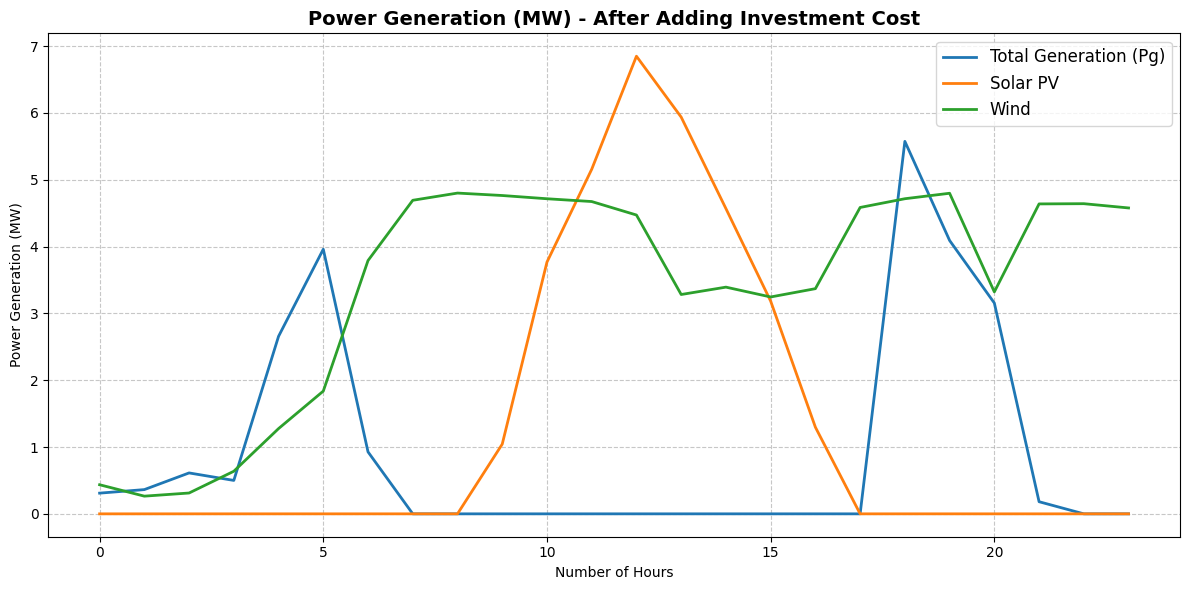

In [178]:
#getting the contribution of wind and PV to overall generation
power_distribution = np.zeros((Nt,4))
#print(power_distribution)
for t in set_T:
    power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
    power_distribution[t-1,2]=np.sum(pv[t-1,i-1]*0.001 for i in range(1,Nb))
    power_distribution[t-1,3]=np.sum(wind[t-1,i-1]*0.001 for i in range(1,Nb))
power_distribution[:,0]= np.arange(24)
df = pd.DataFrame(power_distribution, columns=["x","Pg", "PV", "Wind"])
ax = df.plot(
    x="x",
    y=["Pg", "PV", "Wind"],
    kind="line",
    rot=0,
    figsize=(12, 6),
    linewidth=2,
    xlabel="Number of Hours",
    ylabel="Power Generation (MW)",
)
ax.set_title("Power Generation (MW) - After Adding Investment Cost", fontsize=14, weight='bold')
ax.legend(["Total Generation (Pg)", "Solar PV", "Wind"], fontsize=12, loc="upper right")
ax.grid(True, linestyle="--", alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()
total_dis = power_distribution.sum(axis=0)

total_dis = total_dis[1:4]*100/np.sum(total_dis[1:4])

import matplotlib.pyplot as plt

The graph shows the hourly power generation variation after considering the investment cost of batteries, which remains identical to the first scenario (Adding Renewable Energy Sources without Batteries). Adding batteries is not economically viable, as their lifecycle cost remains high.

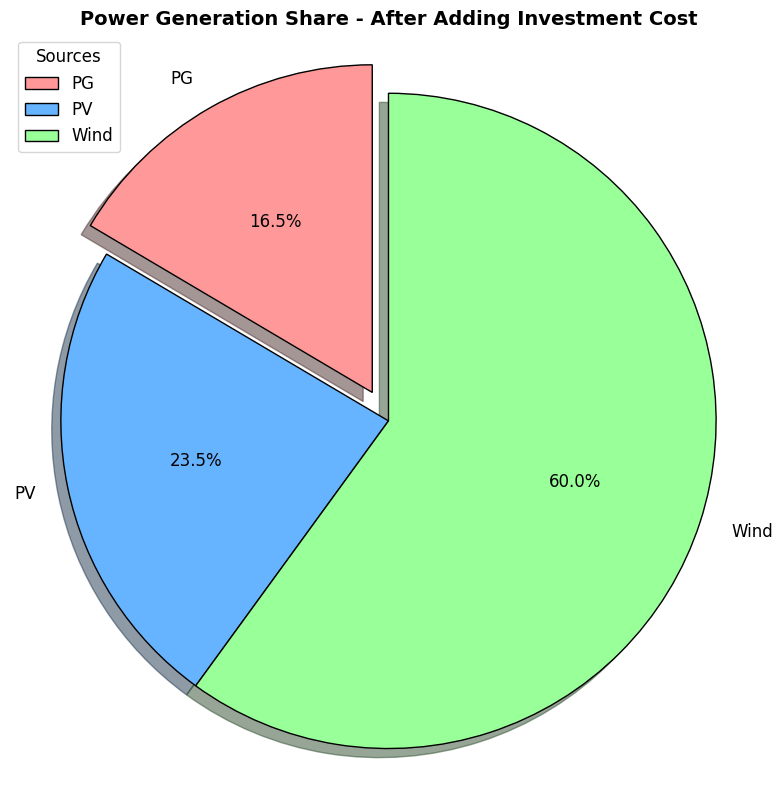

In [179]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ["PG", "PV", "Wind"]
sizes = total_dis
explode = (0.1, 0, 0)  # "explode" PG for emphasis
colors = ["#ff9999", "#66b3ff", "#99ff99"]  # Custom colors for better visualization

# Create the pie chart
fig1, ax1 = plt.subplots(figsize=(8, 8))  # Larger figure for better readability
wedges, texts, autotexts = ax1.pie(
    sizes,
    explode=explode,
    labels=labels,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12},  # Increase font size of labels
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'},  # Add edge for better distinction
)

# Set the title
ax1.set_title("Power Generation Share - After Adding Investment Cost", fontsize=14, weight="bold")

# Customize the legend
ax1.legend(
    wedges,
    labels,
    title="Sources",
    loc="upper left",
    fontsize=12,
    title_fontsize=12,
)

# Ensure the pie chart is a perfect circle
ax1.axis('equal')

# Display the chart
plt.tight_layout()
plt.show()


The Pie Chart also support the point that High Investment Cost has led to negation of the positive impact created by addition of Batteries. Due to high investment cost, batteries are not used and Daily Power Generation share has become equivalent to 1st case ( Adding Renewable Energy Sources without Batteries)

## **5. Perform a parametric study by varying the investment cost of the batteries (start from 1500 euros/kWh and decrease the investment cost). What is the impact on the objective function and the RE share?**

In [ ]:
def parametric (Inv_cost):
  # Create the 'electrical_Network' variable to contain the problem data
  electrical_Network = LpProblem("electrical_Network", LpMinimize)


  # Add the objective function
  electrical_Network += lpSum(genCost[i-1]*Pg_it[i][t]*1000 + (B_cap[i][t]*Inv_cost*1000)/(365*8) for i in set_I for t in set_T)

  # Energy balance in the nodes
  for t in set_T:
      for i in set_I:
          electrical_Network += Pg_it[i][t] - loads[t-1,i-1] + pv[t-1,i-1]*0.001 + wind[t-1,i-1]*0.001 - B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency) >= P_it[i][t]

  # Energy balance in the network (constraint)
  for t in set_T:
      for i in set_I:
          electrical_Network += P_it[i][t] == lpSum(Mi[j-1,i-1]*Pl_it[j][t] for j in set_L)

  # Maximal power generation (constraint)
  for t in set_T:
      for i in set_I:
          electrical_Network += Pg_it[i][t] <= genMax[i-1]

  #Battery State of Charge Equation
  for t in set_T:
      for i in set_I:
        if t>1:
          electrical_Network += B_cap[i][t] == B_cap[i][t-1] + B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency)
        else:
          electrical_Network += B_cap[i][t] == 0.0 + B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency)

  # Solve the problem using Pip Model
  electrical_Network.solve()
  # The status of the solution is printed to the screen
  # print("Status:", LpStatus[electrical_Network.status])
  # The Optimal Generation Cost
  # print ("Optimal generation cost = ", value(electrical_Network.objective))
  #getting the contribution of wind and PV to overall generation
  power_distribution = np.zeros((Nt,4))
  #print(power_distribution)
  for t in set_T:
      power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
      power_distribution[t-1,2]=np.sum(pv[t-1,i-1]*0.001 for i in range(1,Nb))
      power_distribution[t-1,3]=np.sum(wind[t-1,i-1]*0.001 for i in range(1,Nb))
  power_distribution[:,0]= np.arange(24)
  Pg_total=np.sum(power_distribution[:,1])
  Ppv_total=np.sum(power_distribution[:,2])
  Pw_total=np.sum(power_distribution[:,3])
  Pg_share=100*Pg_total/(Pg_total+Ppv_total+Pw_total)
  #print("The Pg production is = ", Pg_total, "MW")
  #print("The Pg share is = ",Pg_share, "%")
  Ppv_share=100*Ppv_total/(Pg_total+Ppv_total+Pw_total)
  #print("The PV production is = ", Ppv_total, "MW" )
  #print("The PV share is = ", Ppv_share , "%")
  Pw_share=100*Pw_total/(Pg_total+Ppv_total+Pw_total)
  #print("The WT production is =", Pw_total, "MW")
  #print("The WT share is = ", Pw_share, "%")

  return  [Inv_cost, LpStatus[electrical_Network.status],
           value(electrical_Network.objective) ,
           Pg_total,
           Pg_share,
           Ppv_total,
           Ppv_share,
           Pw_total,
           Pw_share]

In [ ]:
# For creating a DataFrame
# For Merging Output of Fucntion, First it should be converted into Series.
# Append command only add Series Horizontally to Existing DataFrame
# Concat command allow layers to be added horizontally as well as vertically
  # b=pd.Series(parametric(Inv_cost),index=cv)
  #df=pd.DataFrame(b,index=cv)
  #df=pd.concat([df,pd.Series(parametric(1400),index=cv)],axis=1) # Concatenation require the data should be converted to Series.

In [ ]:
print("The Program will perform parametric study of the Objective function and RE share with respect to the Investment cost of the batteries \n")

Inv_cost = 1500
cv = ['Inv_cost', 'Status', 'Gen_Cost', 'Pg_total', 'Pg_share', 'Ppv_total', 'Ppv_share', 'Pw_total', 'Pw_share']
a = np.zeros((1, 9))
df = pd.DataFrame(a, columns=cv)

# Initial row using pd.concat
df = pd.concat([df, pd.DataFrame([parametric(Inv_cost)], columns=cv)], ignore_index=True)

while Inv_cost > 10:
    Inv_cost *= 0.9
    # Append rows using pd.concat
    df = pd.concat([df, pd.DataFrame([parametric(Inv_cost)], columns=cv)], ignore_index=True)

df = df.drop(index=0)  # Drop the initial null row
df.head(5)  # Display the first 5 rows


The Program will perform parametric study of the Objective function and RE share with respect to the Investment cost of the batteries 



<ipython-input-138-3995a16ab748>:42: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,1]=np.sum(value(Pg_it[i][t]) for i in range(1,Nb))
<ipython-input-138-3995a16ab748>:43: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,2]=np.sum(pv[t-1,i-1]*0.001 for i in range(1,Nb))
<ipython-input-138-3995a16ab748>:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1,3]=np.sum(wind[t-1,i-1]*0.001 for i in range(1,Nb))


,Inv_cost,Status,Gen_Cost,Pg_total,Pg_share,Ppv_total,Ppv_share,Pw_total,Pw_share
1,1500.00,Optimal,1918.12016,22.328099,16.495621,31.798537,23.492219,81.231103,60.01216
2,1350.00,Optimal,1918.12016,22.328099,16.495621,31.798537,23.492219,81.231103,60.01216
3,1215.00,Optimal,1918.12016,22.328099,16.495621,31.798537,23.492219,81.231103,60.01216
4,1093.50,Optimal,1918.12016,22.328099,16.495621,31.798537,23.492219,81.231103,60.01216
5,984.15,Optimal,1918.12016,22.328099,16.495621,31.798537,23.492219,81.231103,60.01216


In [ ]:
df.describe()

,Inv_cost,Gen_Cost,Pg_total,Pg_share,Ppv_total,Ppv_share,Pw_total,Pw_share
count,49.000000,49.000000,49.000000,49.000000,4.900000e+01,49.000000,4.900000e+01,49.000000
mean,304.369464,1583.983872,17.679621,13.360988,3.179854e+01,24.374083,8.123110e+01,62.264929
std,390.040574,298.174775,5.686566,3.870513,2.153718e-14,1.088888,4.307436e-14,2.781625
min,9.544028,932.680301,9.327769,7.623379,3.179854e+01,23.492219,8.123110e+01,60.012160
25%,33.792599,1402.578600,11.050193,8.905712,3.179854e+01,23.492219,8.123110e+01,60.012160
50%,119.649665,1784.154882,21.754400,16.140190,3.179854e+01,23.592212,8.123110e+01,60.267598
75%,423.644305,1791.984910,22.328099,16.495621,3.179854e+01,25.627482,8.123110e+01,65.466806
max,1500.000000,1791.984910,22.328099,16.495621,3.179854e+01,25.988240,8.123110e+01,66.388381


<Figure size 1400x700 with 0 Axes>

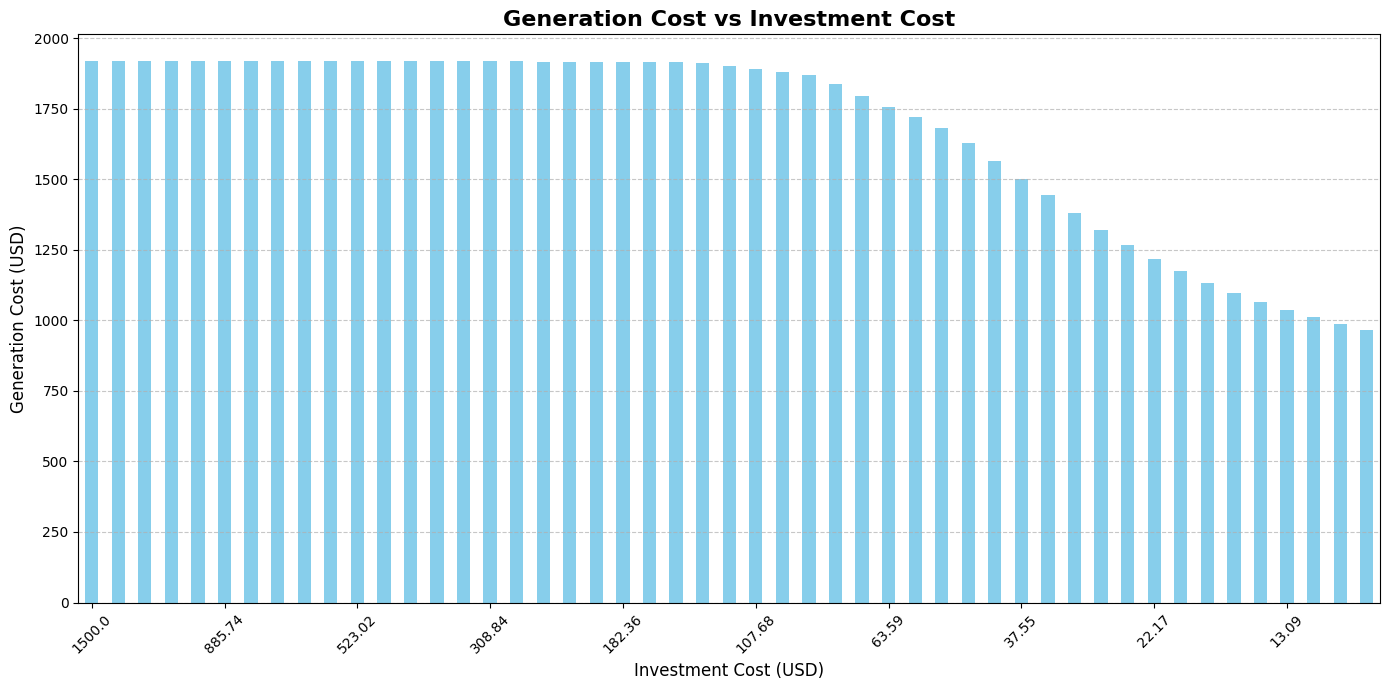

<Figure size 1400x700 with 0 Axes>

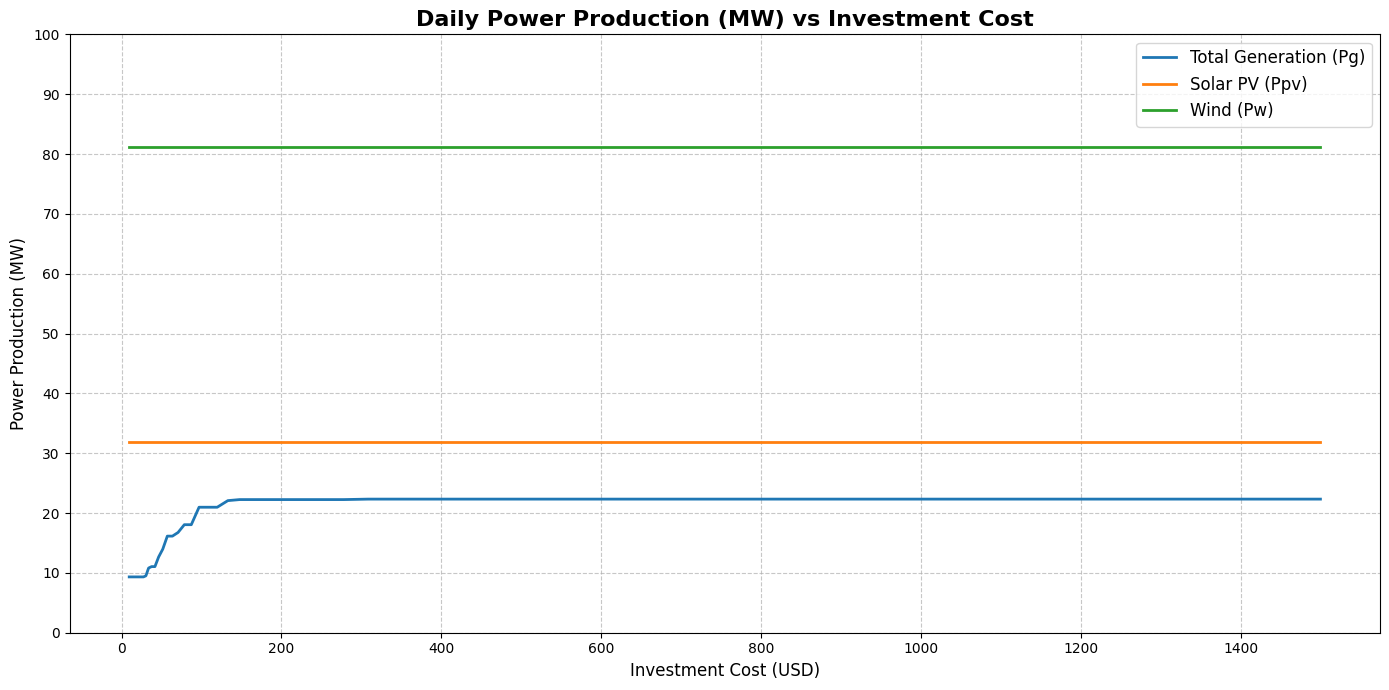

<Figure size 1400x700 with 0 Axes>

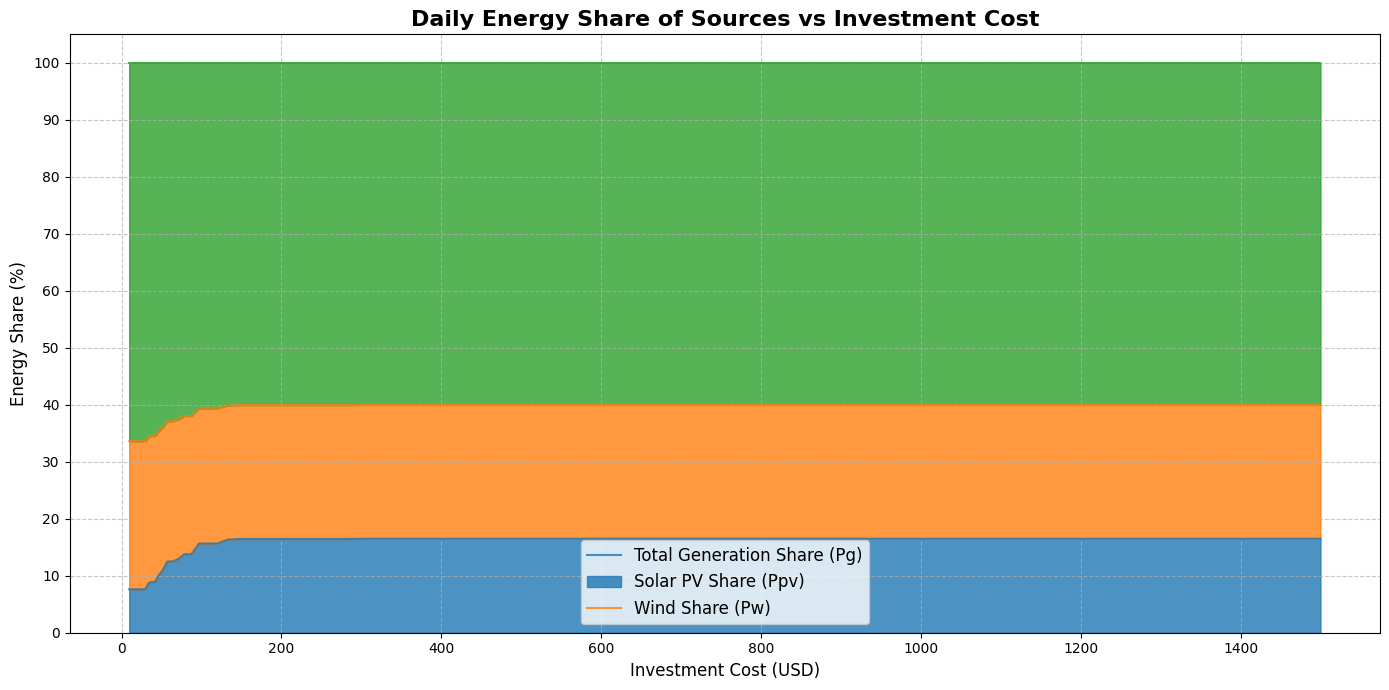

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Improved bar chart for Generation Cost vs Investment Cost
plt.figure(figsize=(14, 7))  # Larger figure for better readability
ax3 = df.plot(
    x="Inv_cost",
    y=["Gen_Cost"],
    kind="bar",
    rot=0,
    figsize=(14, 7),
    color="skyblue",
    legend=False,
)
plt.title("Generation Cost vs Investment Cost", fontsize=16, weight="bold")
plt.xlabel("Investment Cost (USD)", fontsize=12)
plt.ylabel("Generation Cost (USD)", fontsize=12)
plt.xticks(
    ticks=range(0, len(df), 5),
    labels=df["Inv_cost"][::5].round(2),
    fontsize=10,
    rotation=45,
)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add horizontal gridlines
plt.tight_layout()  # Prevent label overlap
plt.show()

# Improved line chart for Daily Power Production (MW) vs Investment Cost
plt.figure(figsize=(14, 7))  # Larger figure for better readability
ax1 = df.plot(
    x="Inv_cost",
    y=["Pg_total", "Ppv_total", "Pw_total"],
    kind="line",
    linewidth=2,
    rot=0,
    figsize=(14, 7),
)
plt.title("Daily Power Production (MW) vs Investment Cost", fontsize=16, weight="bold")
plt.xlabel("Investment Cost (USD)", fontsize=12)
plt.ylabel("Power Production (MW)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(np.arange(0, 110, 10), fontsize=10)
plt.grid(linestyle="--", alpha=0.7)  # Add gridlines for better readability
plt.legend(["Total Generation (Pg)", "Solar PV (Ppv)", "Wind (Pw)"], fontsize=12)
plt.tight_layout()
plt.show()

# Improved area chart for Daily Energy Share of Sources vs Investment Cost
plt.figure(figsize=(14, 7))  # Larger figure for better readability
ax2 = df.plot(
    x="Inv_cost",
    y=["Pg_share", "Ppv_share", "Pw_share"],
    kind="area",
    alpha=0.8,
    rot=0,
    figsize=(14, 7),
)
plt.title("Daily Energy Share of Sources vs Investment Cost", fontsize=16, weight="bold")
plt.xlabel("Investment Cost (USD)", fontsize=12)
plt.ylabel("Energy Share (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(np.arange(0, 110, 10), fontsize=10)
plt.grid(linestyle="--", alpha=0.7)  # Add gridlines for better readability
plt.legend(["Total Generation Share (Pg)", "Solar PV Share (Ppv)", "Wind Share (Pw)"], fontsize=12)
plt.tight_layout()
plt.show()


The parametric analysis indicates the following insights:

**Economic Viability of Batteries:**

If the investment cost of batteries is reduced below 150 Euros/KWh, their installation becomes economically viable.
As shown in the graphs, moving left along the x-axis (lower investment costs) results in:
An increase in the share of Photovoltaic (PV) and Wind Power in annual energy consumption.
A linear decrease in Gas Engine Power Production as the cost of batteries decreases from 150 Euros/KWh to 10 Euros/KWh.

**Generation Cost Trends:**

The Generation Cost vs Investment Cost graph shows that moving right along the x-axis (lower investment costs):
Generation costs decrease gradually, particularly beyond 150 Euros/KWh, reflecting improved cost-efficiency with lower battery investment costs.

## **6. Add a CO2 emission constraint considering an emission factor of the classical generators of 0,583 t CO2 eq /MWh. Perform a parametric study by varying the maximum allowable CO2 emission. What is the impact on the Objective function and RE share.**

<ipython-input-143-558ec57b3297>:51: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1, 1] = np.sum(value(Pg_it[i][t]) for i in range(1, Nb))
<ipython-input-143-558ec57b3297>:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1, 2] = np.sum(pv[t-1, i-1]*0.001 for i in range(1, Nb))
<ipython-input-143-558ec57b3297>:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  power_distribution[t-1, 3] = np.sum(wind[t-1, i-1]*0.001 for i in range(1, Nb))


<Figure size 1400x700 with 0 Axes>

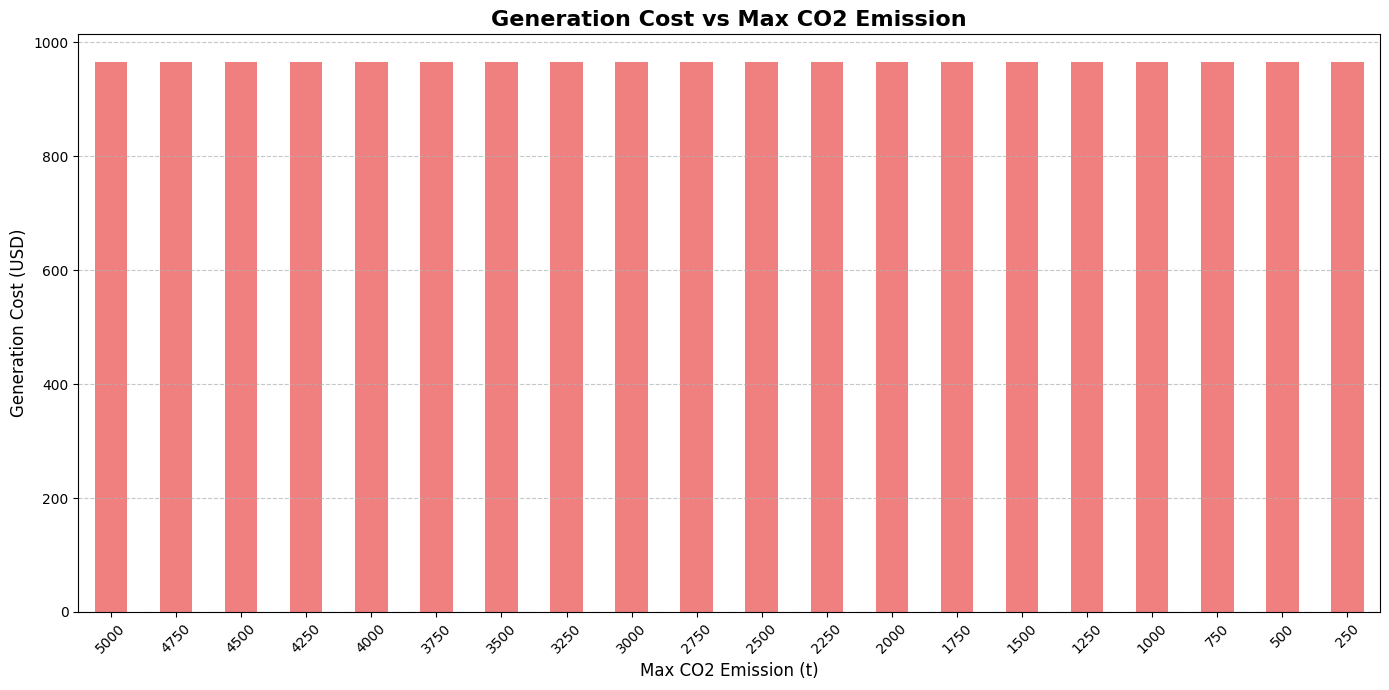

<Figure size 1400x700 with 0 Axes>

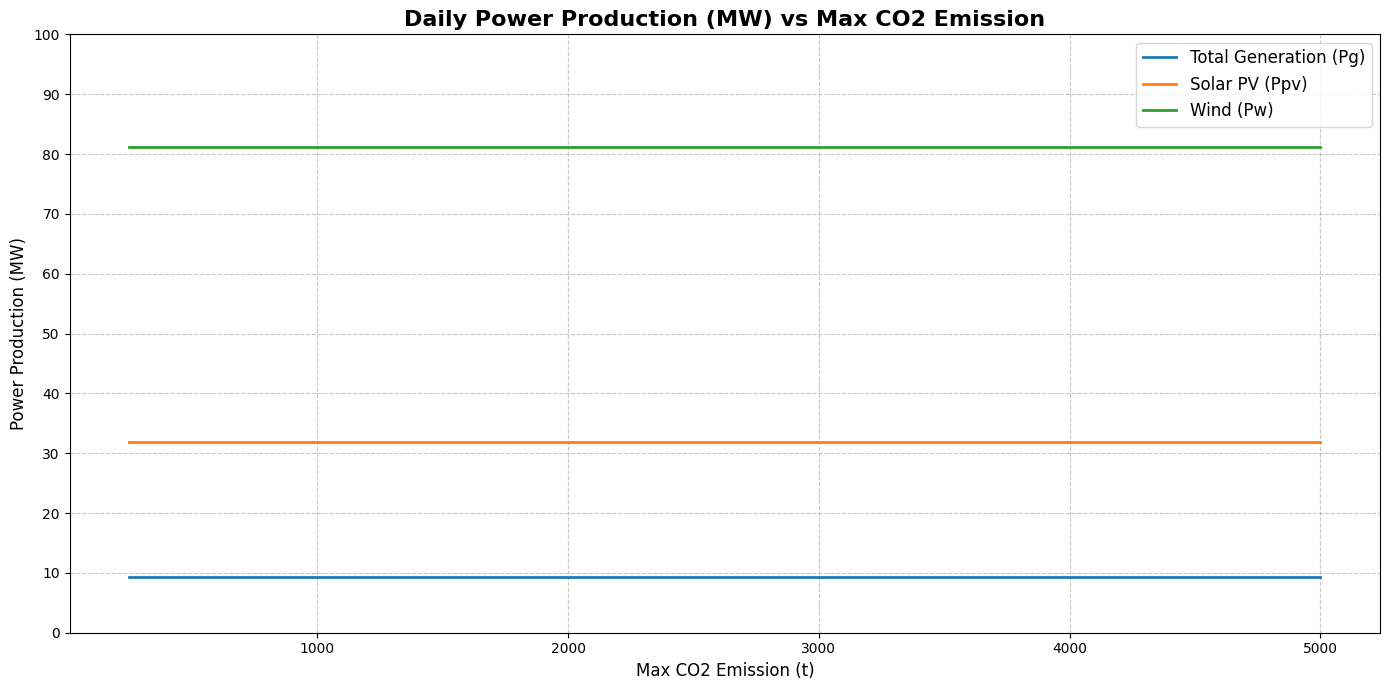

<Figure size 1400x700 with 0 Axes>

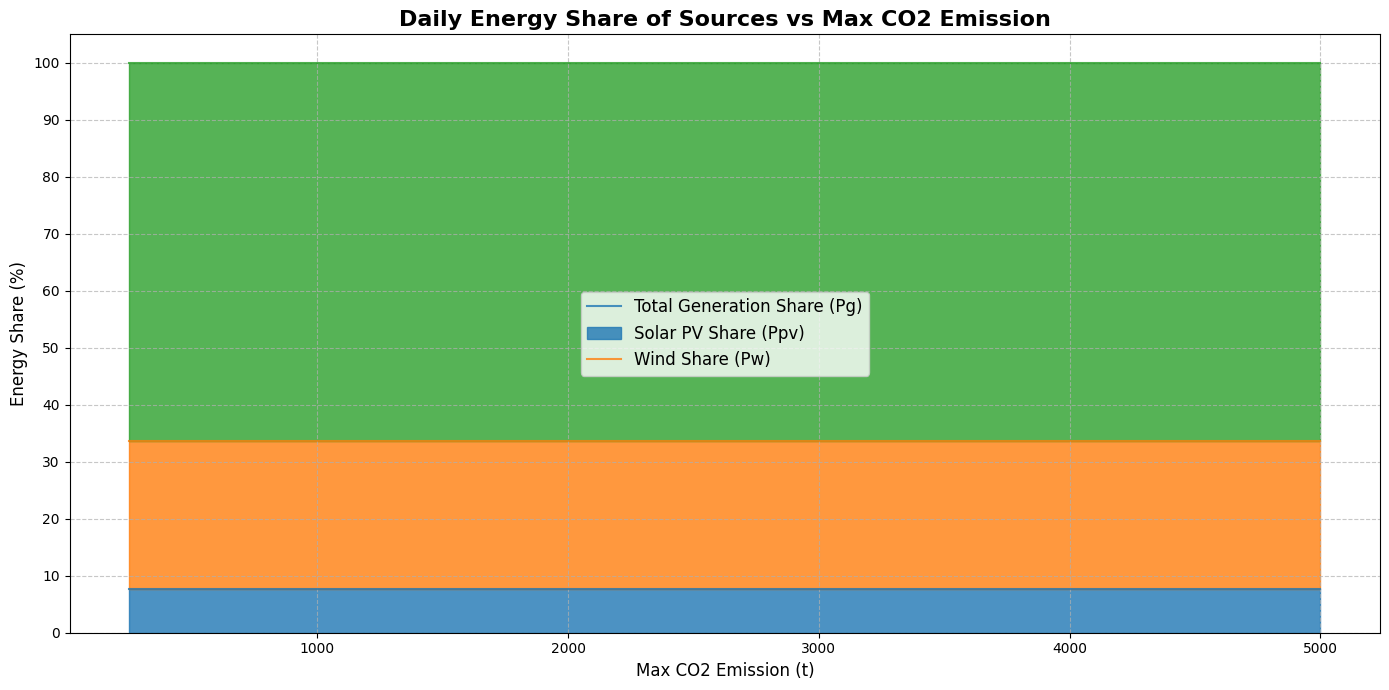

In [ ]:
from pulp import LpProblem, LpMinimize, lpSum, LpVariable, LpStatus, value
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the parametric function for CO2 emissions

def parametric(co2_emission_factor, max_CO2_emission):
    # Create the 'electrical_Network' variable to contain the problem data
    electrical_Network = LpProblem("electrical_Network", LpMinimize)

    # Add the objective function
    electrical_Network += lpSum(genCost[i-1]*Pg_it[i][t]*1000 + (B_cap[i][t]*Inv_cost*1000)/(365*8) for i in set_I for t in set_T)

    # Energy balance in the nodes
    for t in set_T:
        for i in set_I:
            electrical_Network += Pg_it[i][t] - loads[t-1,i-1] + pv[t-1,i-1]*0.001 + wind[t-1,i-1]*0.001 - B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency) >= P_it[i][t]

    # Energy balance in the network (constraint)
    for t in set_T:
        for i in set_I:
            electrical_Network += P_it[i][t] == lpSum(Mi[j-1,i-1]*Pl_it[j][t] for j in set_L)

    # Maximal power generation (constraint)
    for t in set_T:
        for i in set_I:
            electrical_Network += Pg_it[i][t] <= genMax[i-1]

    # Battery State of Charge Equation
    for t in set_T:
        for i in set_I:
            if t > 1:
                electrical_Network += B_cap[i][t] == B_cap[i][t-1] + B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency)
            else:
                electrical_Network += B_cap[i][t] == 0.0 + B_chg_MAX*batt[i-1]*(B_ch[i][t]*chFactor - B_dch[i][t]*disEfficiency)

    # Add CO2 emission constraint
    electrical_Network += lpSum(co2_emission_factor * Pg_it[i][t] for i in set_I for t in set_T) <= max_CO2_emission

    # Solve the problem using Pulp Model
    electrical_Network.solve()

    # Check for infeasibility
    if LpStatus[electrical_Network.status] != "Optimal":
        return [max_CO2_emission, LpStatus[electrical_Network.status], None, None, None, None, None, None, None]

    # Calculate power distribution and shares
    power_distribution = np.zeros((Nt, 4))
    for t in set_T:
        power_distribution[t-1, 1] = np.sum(value(Pg_it[i][t]) for i in range(1, Nb))
        power_distribution[t-1, 2] = np.sum(pv[t-1, i-1]*0.001 for i in range(1, Nb))
        power_distribution[t-1, 3] = np.sum(wind[t-1, i-1]*0.001 for i in range(1, Nb))
    power_distribution[:, 0] = np.arange(24)
    Pg_total = np.sum(power_distribution[:, 1])
    Ppv_total = np.sum(power_distribution[:, 2])
    Pw_total = np.sum(power_distribution[:, 3])
    Pg_share = 100 * Pg_total / (Pg_total + Ppv_total + Pw_total)
    Ppv_share = 100 * Ppv_total / (Pg_total + Ppv_total + Pw_total)
    Pw_share = 100 * Pw_total / (Pg_total + Ppv_total + Pw_total)

    return [max_CO2_emission, LpStatus[electrical_Network.status],
            value(electrical_Network.objective),
            Pg_total,
            Pg_share,
            Ppv_total,
            Ppv_share,
            Pw_total,
            Pw_share]  # For creating a DataFrame

# Initialization of parameters for the parametric study
max_CO2_emission = 5000  # Starting maximum CO2 emissions in t CO2, lowered to tighten the constraint
co2_emission_factor = 0.583  # CO2 emission factor in t CO2/MWh
cv = ['Max_CO2_Emission', 'Status', 'Gen_Cost', 'Pg_total', 'Pg_share', 'Ppv_total', 'Ppv_share', 'Pw_total', 'Pw_share']
a = np.zeros((1, 9))
df = pd.DataFrame(a, columns=cv)

# Initial row using pd.concat
df = pd.concat([df, pd.DataFrame([parametric(co2_emission_factor, max_CO2_emission)], columns=cv)], ignore_index=True)

# Perform parametric analysis by reducing max CO2 emission
while max_CO2_emission > 100:
    max_CO2_emission -= 250  # Decrease CO2 limit more aggressively
    result = parametric(co2_emission_factor, max_CO2_emission)
    if result[2] is not None:  # Only append if the solution is feasible
        df = pd.concat([df, pd.DataFrame([result], columns=cv)], ignore_index=True)

df = df.drop(index=0)  # Drop the initial null row

# Plot results
import matplotlib.pyplot as plt
import numpy as np

# Improved bar chart for Generation Cost vs Max CO2 Emission
plt.figure(figsize=(14, 7))  # Larger figure for better readability
ax3 = df.plot(
    x="Max_CO2_Emission",
    y=["Gen_Cost"],
    kind="bar",
    rot=0,
    color="lightcoral",
    legend=False,
    figsize=(14, 7),
)
plt.title("Generation Cost vs Max CO2 Emission", fontsize=16, weight="bold")
plt.xlabel("Max CO2 Emission (t)", fontsize=12)
plt.ylabel("Generation Cost (USD)", fontsize=12)
plt.xticks(
    ticks=range(0, len(df), 1),
    labels=df["Max_CO2_Emission"].astype(int),
    fontsize=10,
    rotation=45,
)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add horizontal gridlines
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

#  line chart for Daily Power Production (MW) vs Max CO2 Emission
plt.figure(figsize=(14, 7))  # Larger figure for better readability
ax1 = df.plot(
    x="Max_CO2_Emission",
    y=["Pg_total", "Ppv_total", "Pw_total"],
    kind="line",
    linewidth=2,
    rot=0,
    figsize=(14, 7),
)
plt.title("Daily Power Production (MW) vs Max CO2 Emission", fontsize=16, weight="bold")
plt.xlabel("Max CO2 Emission (t)", fontsize=12)
plt.ylabel("Power Production (MW)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(np.arange(0, 110, 10), fontsize=10)
plt.grid(linestyle="--", alpha=0.7)  # Add gridlines for better readability
plt.legend(["Total Generation (Pg)", "Solar PV (Ppv)", "Wind (Pw)"], fontsize=12)
plt.tight_layout()
plt.show()

# Improved area chart for Daily Energy Share of Sources vs Max CO2 Emission
plt.figure(figsize=(14, 7))  # Larger figure for better readability
ax2 = df.plot(
    x="Max_CO2_Emission",
    y=["Pg_share", "Ppv_share", "Pw_share"],
    kind="area",
    alpha=0.8,
    rot=0,
    figsize=(14, 7),
)
plt.title("Daily Energy Share of Sources vs Max CO2 Emission", fontsize=16, weight="bold")
plt.xlabel("Max CO2 Emission (t)", fontsize=12)
plt.ylabel("Energy Share (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(np.arange(0, 110, 10), fontsize=10)
plt.grid(linestyle="--", alpha=0.7)  # Add gridlines for better readability
plt.legend(["Total Generation Share (Pg)", "Solar PV Share (Ppv)", "Wind Share (Pw)"], fontsize=12)
plt.tight_layout()
plt.show()


The chart "Generation Cost vs Max CO2 Emission" illustrates that the generation cost remains nearly constant as the maximum allowable CO2 emissions decrease. This result reflects the high share of renewable energy (approximately 80%) in the system, which already ensures low CO2 emissions.

High Renewable Penetration: The majority of the energy demand is met by renewable sources such as PV and wind, which have negligible or zero CO2 emissions. This minimizes reliance on fossil fuel-based generators and keeps the system's emissions well below the constraints.

Non-Binding CO2 Constraint: As the CO2 constraint is tightened, it does not significantly impact the system's operation or cost because the emissions from fossil fuel generation are already low. The constraint does not force any additional changes in the generation mix or operational costs.

Cost Effectiveness of Renewables: The predominance of low-cost renewables in the energy mix ensures that the generation cost remains stable, even under stricter environmental regulations.